In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import GridSearchCV
import gc
import os

In [2]:
# Download data from https://drive.google.com/file/d/1rlnfQ2mP673LA29jxrlIyTdSgCbC7nlz/view?usp=sharing

# Data Reading, Rename
all_data =  pd.read_csv("stk_data.csv",index_col=0) # data and code should be in the same folder!!!
all_data.rename(columns={"OpenPrice":"Open","HighPrice":"High","LowPrice":"Low","ClosePrice":"Close","TurnoverVolume":"Volume"},inplace=True)

data = all_data[all_data.Ifsuspend==0].copy()

In [3]:
# Feature Engineering
data['return'] = all_data.groupby('InnerCode')['Close'].pct_change() 

data['SMA_5'] = data.groupby('InnerCode')['Close'].transform(lambda x: x.rolling(window = 5).mean())
data['SMA_15'] = data.groupby('InnerCode')['Close'].transform(lambda x: x.rolling(window = 15).mean())
data['SMA_ratio'] = data['SMA_15'] / data['SMA_5']


data['SMA5_Volume'] = data.groupby('InnerCode')['Volume'].transform(lambda x: x.rolling(window = 5).mean())
data['SMA15_Volume'] = data.groupby('InnerCode')['Volume'].transform(lambda x: x.rolling(window = 15).mean())
data['SMA_Volume_Ratio'] = data['SMA5_Volume']/data['SMA15_Volume']


data['prev_Close'] = data.groupby('InnerCode')['Close'].shift(1)
data['TR'] = np.maximum((data['High'] - data['Low']), 
                    np.maximum(abs(data['High'] - data['prev_Close']), 
                    abs(data['prev_Close'] - data['Low'])))

data['ATR_5'] = data.groupby('InnerCode')['TR'].transform(lambda x: x.rolling(window = 5).mean())
data['ATR_15'] = data.groupby('InnerCode')['TR'].transform(lambda x: x.rolling(window = 15).mean())

data['ATR_Ratio'] = data['ATR_5'] / data['ATR_15']

data['prev_high'] = data.groupby('InnerCode')['High'].shift(1)
data['prev_low'] = data.groupby('InnerCode')['Low'].shift(1)

data['+DM'] = np.where(~np.isnan(data.prev_high),
                        np.where((data['High'] > data['prev_high']) & 
        (((data['High'] - data['prev_high']) > (data['prev_low'] - data['Low']))), 
                                                                data['High'] - data['prev_high'], 
                                                                0),np.nan)

data['-DM'] = np.where(~np.isnan(data.prev_low),
                        np.where((data['prev_low'] > data['Low']) & 
        (((data['prev_low'] - data['Low']) > (data['High'] - data['prev_high']))), 
                                    data['prev_low'] - data['Low'], 
                                    0),np.nan)
data["+DM_5"] = data.groupby('InnerCode')['+DM'].transform(lambda x: x.rolling(window = 5).mean())
data["-DM_5"] = data.groupby('InnerCode')['-DM'].transform(lambda x: x.rolling(window = 5).mean())
data["+DM_15"] = data.groupby('InnerCode')['+DM'].transform(lambda x: x.rolling(window = 15).mean())
data["-DM_15"] = data.groupby('InnerCode')['-DM'].transform(lambda x: x.rolling(window = 15).mean())

data['+DI_5'] = (data['+DM_5']/data['ATR_5'])*100
data['-DI_5'] = (data['-DM_5']/data['ATR_5'])*100
data['+DI_15'] = (data['+DM_15']/data['ATR_15'])*100
data['-DI_15'] = (data['-DM_15']/data['ATR_15'])*100

data['DX_5'] = (np.round(abs(data['+DI_5'] - data['-DI_5'])/(data['+DI_5'] + data['-DI_5']) * 100))

data['DX_15'] = (np.round(abs(data['+DI_15'] - data['-DI_15'])/(data['+DI_15'] + data['-DI_15']) * 100))


data['ADX_5'] = data.groupby('InnerCode')['DX_5'].transform(lambda x: x.rolling(window = 5).mean())
data['ADX_15'] = data.groupby('InnerCode')['DX_15'].transform(lambda x: x.rolling(window = 15).mean())

data['Lowest_5D'] = data.groupby('InnerCode')['Low'].transform(lambda x: x.rolling(window = 5).min())
data['High_5D'] = data.groupby('InnerCode')['High'].transform(lambda x: x.rolling(window = 5).max())
data['Lowest_15D'] = data.groupby('InnerCode')['Low'].transform(lambda x: x.rolling(window = 15).min())
data['High_15D'] = data.groupby('InnerCode')['High'].transform(lambda x: x.rolling(window = 15).max())

data['Stochastic_5'] = ((data['Close'] - data['Lowest_5D'])/(data['High_5D'] - data['Lowest_5D']))*100
data['Stochastic_15'] = ((data['Close'] - data['Lowest_15D'])/(data['High_15D'] - data['Lowest_15D']))*100

data['Stochastic_%D_5'] = data['Stochastic_5'].rolling(window = 5).mean()
data['Stochastic_%D_15'] = data['Stochastic_5'].rolling(window = 15).mean()

data['Stochastic_Ratio'] = data['Stochastic_%D_5']/data['Stochastic_%D_15']


data['Diff'] = data.groupby('InnerCode')['Close'].transform(lambda x: x.diff())
data['Up'] = data['Diff']
data.loc[(data['Up']<0), 'Up'] = 0

data['Down'] = data['Diff']
data.loc[(data['Down']>0), 'Down'] = 0 
data['Down'] = abs(data['Down'])

data['avg_5up'] = data.groupby('InnerCode')['Up'].transform(lambda x: x.rolling(window=5).mean())
data['avg_5down'] = data.groupby('InnerCode')['Down'].transform(lambda x: x.rolling(window=5).mean())

data['avg_15up'] = data.groupby('InnerCode')['Up'].transform(lambda x: x.rolling(window=15).mean())
data['avg_15down'] = data.groupby('InnerCode')['Down'].transform(lambda x: x.rolling(window=15).mean())

data['RS_5'] = data['avg_5up'] / data['avg_5down']
data['RS_15'] = data['avg_15up'] / data['avg_15down']

data['RSI_5'] = 100 - (100/(1+data['RS_5']))
data['RSI_15'] = 100 - (100/(1+data['RS_15']))

data['RSI_ratio'] = data['RSI_5']/data['RSI_15']


data['5Ewm'] = data.groupby('InnerCode')['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
data['15Ewm'] = data.groupby('InnerCode')['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
data['MACD'] = data['15Ewm'] - data['5Ewm']

data['15MA'] = data.groupby('InnerCode')['Close'].transform(lambda x: x.rolling(window=15).mean())
data['SD'] = data.groupby('InnerCode')['Close'].transform(lambda x: x.rolling(window=15).std())
data['upperband'] = data['15MA'] + 2*data['SD']
data['lowerband'] = data['15MA'] - 2*data['SD']

data['RC_5'] = data.groupby('InnerCode')['Close'].transform(lambda x: x.pct_change(periods = 5))
data['RC_15'] = data.groupby('InnerCode')['Close'].transform(lambda x: x.pct_change(periods = 15))

In [4]:
# Feature Engineering
data["aroon_up_5"]=data.groupby('InnerCode')["High"].transform(lambda x :(5- x.rolling(window=5).max())/5)
data["aroon_down_5"]=data.groupby('InnerCode')["Low"].transform(lambda x :(5- x.rolling(window=5).min())/5)
data["aroon_osc_5"] = data["aroon_up_5"]-data["aroon_down_5"]

data["aroon_up_15"]=data.groupby('InnerCode')["High"].transform(lambda x :(15- x.rolling(window=15).max())/15)
data["aroon_down_15"]=data.groupby('InnerCode')["Low"].transform(lambda x :(15- x.rolling(window=15).min())/15)
data["aroon_osc_15"] = data["aroon_up_15"]-data["aroon_down_15"]

data["HHigh_5"] = data.groupby("InnerCode")["High"].transform(lambda x: x.rolling(window=5).max())
data["LLow_5"] = data.groupby("InnerCode")["Low"].transform(lambda x: x.rolling(window=5).min())


data["TP_5"]= (data["Close"]+data["HHigh_5"]+data["LLow_5"])/3
data["TP_M_5"] = data.groupby("InnerCode")["TP_5"].transform(lambda x: x.rolling(window=5).mean())
data["temp"] = (data["TP_5"]-data["TP_M_5"]).abs()
data["TP_D_5"] = data.groupby("InnerCode")["temp"].transform(lambda x: x.rolling(window=5).mean())

data["CCI_5"] = (data["TP_5"]-data["TP_M_5"])/(0.015*data["TP_D_5"])

data["HHigh_15"] = data.groupby("InnerCode")["High"].transform(lambda x: x.rolling(window=15).max())
data["LLow_15"] = data.groupby("InnerCode")["Low"].transform(lambda x: x.rolling(window=15).min())


data["TP_15"]= (data["Close"]+data["HHigh_15"]+data["LLow_15"])/3
data["TP_M_15"] = data.groupby("InnerCode")["TP_15"].transform(lambda x: x.rolling(window=15).mean())
data["temp"] = (data["TP_15"]-data["TP_M_15"]).abs()
data["TP_D_15"] = data.groupby("InnerCode")["temp"].transform(lambda x: x.rolling(window=15).mean())

data["CCI_15"] = (data["TP_15"]-data["TP_M_15"])/(0.015*data["TP_D_15"])

data["Mom_5"]=data.groupby("InnerCode")["Close"].transform(lambda x : x-x.shift(5))
data["Mom_15"]=data.groupby("InnerCode")["Close"].transform(lambda x : x-x.shift(15))

data["PPO"] = (data['SMA_15']- data['SMA_5'])/data['SMA_5']

data["Williams_5"]=(data["HHigh_5"]-data["Close"])/(data["HHigh_5"]-data["LLow_5"])
data["Williams_15"]=(data["HHigh_15"]-data["Close"])/(data["HHigh_15"]-data["LLow_15"])

In [5]:
# Label Creating
data['Target'] = ((data['Close'] - data['Open'])/(data['Open']) * 100).shift(-1)
data['Target_Direction'] = np.where(data['Target']>0,1,0)
data.dropna(inplace=True)

In [6]:
# Feature selection
Target_variables = ['SMA_ratio','ATR_5','ATR_15','ATR_Ratio',
                       'ADX_5','ADX_15','SMA_Volume_Ratio','Stochastic_5','Stochastic_15','Stochastic_Ratio',
                      'RSI_5','RSI_15','RSI_ratio','MACD','upperband','lowerband','RC_5','RC_15',"aroon_up_5","aroon_down_5","aroon_osc_5",
                      "aroon_up_15","aroon_down_15","aroon_osc_15","CCI_5","CCI_15","Mom_5","Mom_15","PPO","Williams_5","Williams_15"]

In [7]:
# Filter out stoch which has less than 1000 data
temp =(data.groupby("InnerCode")["TradingDay"].count()>1000).reset_index()
lst=temp[temp.TradingDay]["InnerCode"].values.tolist()
data = data[data.InnerCode.isin(lst)].copy()

In [8]:
# Train Test Split
Train = data[data.TradingDay<'2020-01-01'].copy()
Test = data[data.TradingDay>='2020-01-01'].copy()

X_train = Train.loc[:,Target_variables].values
X_test = Test.loc[:,Target_variables].values

In [9]:
# MinMaxScaler
scalar = MinMaxScaler()
scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

Train.loc[:,Target_variables]=X_train
Test.loc[:,Target_variables]=X_test

D:\Programing\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


,Difference in SS
1,NaN
2,-25.948801
3,-24.459727
4,-13.220133
5,-5.453964
6,-10.112895
7,-11.884904
8,0.067069
9,-9.170319
10,-2.659103


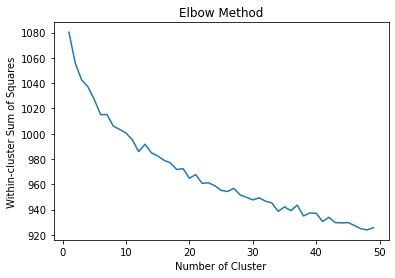

In [10]:
# Determine the number of clusters
#Extract the returns
returns = Train[['InnerCode','return',"TradingDay"]].copy()

#Pivot the returns to create series of returns for each stock 
transposed = returns.pivot(index = 'TradingDay', columns = 'InnerCode', values = 'return').ffill()

#Transpose the data to get companies on the index level and dates on the column level since clusters takes place on index level
X = transposed.dropna().transpose().values

#Extract sum of squares for K-means clusters from 1 to 50 clusters
sum_of_sq = np.zeros([50, 1])
for k in range(1, 51):
    sum_of_sq[k-1] = KMeans(n_clusters=k).fit(X).inertia_
    
plt.plot(range(1, 50), sum_of_sq[1:50])
plt.title("Elbow Method") 
plt.xlabel("Number of Cluster") 
plt.ylabel("Within-cluster Sum of Squares")

pd.DataFrame(sum_of_sq, columns = ['Difference in SS'], index = range(1,51)).diff()

In [31]:
#Classify stocks into 8 clusters
returns = Train[['InnerCode','return',"TradingDay"]].copy()

#Pivot the returns to create series of returns for each stock 
transposed = returns.pivot(index = 'TradingDay', columns = 'InnerCode', values = 'return').ffill()

gmm = GaussianMixture(n_components = 8)
gmm.fit(transposed.dropna().transpose().values)

#Predict for each company
clusters = gmm.predict(transposed.dropna().transpose().values)
clusters_df = pd.DataFrame({'Cluster':clusters,
                           'Companies':transposed.columns})

#Sort by Clusters
clusters_df = clusters_df.sort_values(['Cluster']).reset_index(drop = True)

#Save as csv
# clusters_df.to_csv("clusters.csv")

In [32]:
# You have to rerun the code if the number of companies in some clusters is small. We have to gather enough data for training!!!
# Or you can use the clusters.csv I give you.
clusters_df.groupby("Cluster").count()

,Companies
Cluster,
0,31
1,53
2,1239
3,474
4,55
5,279
6,74
7,1006


In [33]:
clusters_df = pd.read_csv("clusters.csv")

In [34]:
# Train Based on Clusters
# This is Training part, I have provided the training result (Model saved in a file), you can skip it if you do not want to train
for cluster_selected in clusters_df.Cluster.unique():
    
    print(f'The current cluster running is : {cluster_selected}')
    
    #Get data for that cluster
    co_train = Train[Train.InnerCode.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
    
    X_train = co_train.loc[:,Target_variables].values
    Y_train = co_train.loc[:,['Target_Direction']].values.ravel()

    #Define paramters from Validation Curve
    params = {'max_depth': [5, 7],
          'max_features': ['sqrt'],
          'min_samples_leaf': [10, 15, 20],
          'n_estimators': [5, 7, 9],
         'min_samples_split':[20, 25, 30]} #Using Validation Curves

    rf = RandomForestClassifier()

    #Perform a TimeSeriesSplit on the dataset
    time_series_split = TimeSeriesSplit(n_splits = 3)

    
    rf_cv = GridSearchCV(rf, params, cv = time_series_split, n_jobs = -1)

    #Fit the random forest with our X_train and Y_train
    rf_cv.fit(X_train, Y_train)
          
    #Save the fited variable into a Pickle file
    file_loc = f'{os.getcwd()}/Pickle_Files/Cluster_{cluster_selected}'    
    pickle.dump(rf_cv, open(file_loc,'wb'))

    gc.collect()

The current cluster running is : 0
The current cluster running is : 1
The current cluster running is : 2
The current cluster running is : 3
The current cluster running is : 4
The current cluster running is : 5
The current cluster running is : 6
The current cluster running is : 7


In [35]:
Test.index = Test.TradingDay

In [36]:
# BackTesting
total = 1
select = 20
result = pd.DataFrame(columns=["Date","total"])
corr=[]
for time in Test.TradingDay.unique().tolist():
    day_data = Test.loc[time]

    pred_for_tomorrow = pd.DataFrame({'Date':[],
                                    'InnerCode':[],
                                    'prediction':[]})

    for cluster_selected in clusters_df.Cluster.unique():
        rf_cv =  pickle.load(open(os.getcwd() + f'/Pickle_Files/Cluster_{cluster_selected}', 'rb'))
        best_rf = rf_cv.best_estimator_
        cluster_data = day_data.loc[day_data.InnerCode.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
        cluster_data = cluster_data.dropna()
        if (cluster_data.shape[0]>0):
            X_test = cluster_data.loc[:,Target_variables].values
            pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
                                                                    'InnerCode':cluster_data['InnerCode'],
                                                                    'prediction':best_rf.predict_proba(X_test)[:,1]}), ignore_index = True)
    pct_change = Test[Test.InnerCode.isin(pred_for_tomorrow.InnerCode)].loc[time,['Target',"InnerCode"]]
    pred_for_tomorrow=pd.merge(pred_for_tomorrow,pct_change,on="InnerCode",how="inner")
    top_10_pred = pred_for_tomorrow.sort_values(by = ['prediction'], ascending = False).head(select)
    average = total/select
    total=np.sum(average*(top_10_pred["Target"].values/100+1))
    result = result.append(pd.DataFrame.from_dict({"Date":[time],"total":[total]}))
    corr.append(pred_for_tomorrow[['prediction','Target']].corr(method="spearman").iloc[0,1])
    print(time)
    print("Total:%.2f"%(total))
    print("----------------------")
print(total)

2020-01-02
Total:1.01
----------------------
2020-01-03
Total:1.02
----------------------
2020-01-06
Total:1.04
----------------------
2020-01-07
Total:1.03
----------------------
2020-01-08
Total:1.04
----------------------
2020-01-09
Total:1.03
----------------------
2020-01-10
Total:1.04
----------------------
2020-01-13
Total:1.04
----------------------
2020-01-14
Total:1.05
----------------------
2020-01-15
Total:1.05
----------------------
2020-01-16
Total:1.04
----------------------
2020-01-17
Total:1.05
----------------------
2020-01-20
Total:1.04
----------------------
2020-01-21
Total:1.06
----------------------
2020-01-22
Total:1.03
----------------------
2020-01-23
Total:1.04
----------------------
2020-02-03
Total:1.10
----------------------
2020-02-04
Total:1.13
----------------------
2020-02-05
Total:1.15
----------------------
2020-02-06
Total:1.17
----------------------
2020-02-07
Total:1.20
----------------------
2020-02-10
Total:1.21
----------------------
2020-02-11

In [37]:
result.index = result.Date
result.drop(columns="Date",inplace=True)

In [38]:
def Max_drawdown(series):
    drawdowns = []
    max_so_far = series[0]
    for i in range(1,result.shape[0]):
        if series[i] > max_so_far:
            drawdown = 0
            drawdowns.append(drawdown)
            max_so_far = series[i]
        else:
            drawdown = (max_so_far - series[i])/max_so_far
            drawdowns.append(drawdown)
    return max(drawdowns)

In [23]:
# Result
print(f"maximum drawdown: {Max_drawdown(result.values.reshape(-1))}")
print(f"Average Rank IC:{np.mean(corr)}")
print(f"Daily Mean: {result.pct_change().mean()[0]}")
print(f"Daily Standard Deviation: {result.pct_change().std()[0]}")
print(f"Daily Sharpe Ratio: {result.pct_change().mean()[0]/result.pct_change().std()[0]}")
print(f"Yearly Sharpe Ratio: {result.pct_change().mean()[0]/result.pct_change().std()[0]*np.sqrt(252)}")

maximum drawdown: 0.2136291746018479
Average Rank IC:0.0032730934152101483
Daily Mean: 0.0021145453064093096
Daily Standard Deviation: 0.018128774546034544
Daily Sharpe Ratio: 0.1166402781964014
Yearly Sharpe Ratio: 1.8516070137664056


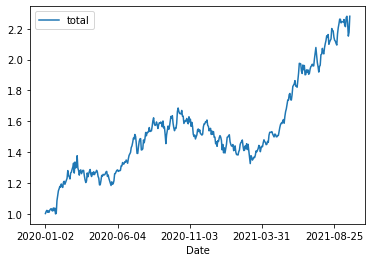

In [24]:
result.plot()
plt.show()

In [41]:
import torch
import torch.nn as nn
import transformers

In [42]:
# Function and classes define

# MLP Class
class MLPBlock(nn.Module):
    def __init__(self,n_input,n_output,ifBatchnorm):
        super(MLPBlock, self).__init__()
        self.linear=nn.Linear(n_input,n_output)
        self.relu=nn.functional.hardtanh
        self.ifBatchnorm=ifBatchnorm
        if ifBatchnorm:
            self.Batchnorm=nn.BatchNorm1d(n_output)
    def forward(self, x):
        out=self.linear(x)
        if self.ifBatchnorm:
            out=self.Batchnorm(out)
        out=self.relu(out,min_val=-1,max_val=1)
        return out
class MLPModel(nn.Module):
    def __init__(self,inputs,ifBatchnorm=True):
        super(MLPModel,self).__init__()
        layers=[]
        num_layers=len(inputs)-1
        for i in range(num_layers):
            if i != num_layers-1:
                layers+=[MLPBlock(inputs[i],inputs[i+1],ifBatchnorm)]
            else:
                self.lastLinear=nn.Linear(inputs[i],inputs[i+1])
        self.network = nn.Sequential(*layers)
    def forward(self,x):
        out=self.network(x)
        out=self.lastLinear(out)
        return out

# Data loader
class n_window_indexer:

    def __init__( self, x_tup, window_len = 32 ):
        self.idxes = {}

        self.idxes['train'], self.idxes['test'], self.idxes['valid'] = np.arange(x_tup[0].shape[0]),\
            np.arange(x_tup[1].shape[0]), np.arange(x_tup[2].shape[0])

        self.window = window_len
        self.n_lookback = self.window

        # maximum len
        self.max_len = len(self.idxes['train']) + len(self.idxes['test']) + \
            len(self.idxes['valid'])

        self.init_lookbacks()

    def init_lookbacks( self ):
        v = []
        for i in range(self.n_lookback + 1):
            prev_n = self.n_lookback - i

            if prev_n > 0:
                this_v = np.hstack((np.ones((prev_n, 1)).reshape(-1,) * i,  np.arange(i, -1, -1).reshape(-1,)))
            else:
                this_v = np.arange(i, -1, -1).reshape(-1,)

            v.append(this_v)
        self.back_inds = np.vstack( v )


        _lookback = np.ones(self.max_len) * self.n_lookback
        _lookback[:self.n_lookback] = np.arange(0, self.n_lookback)

        self.full_lookback = _lookback.astype(int)

    def get_len( self, data_type = 'train', batch_size = 1024):
        the_n = self.idxes[data_type].shape[0]
        the_n_batch = int(np.ceil(the_n / batch_size))

        return the_n_batch

    def iter_data( self, batch_size = 1024, data_type = 'train', shuffle=True, seed = 0, return_ratio = 1.0):

        raw_inds = self.idxes[data_type].copy()
        inds = raw_inds
        self.n = inds.shape[0]
        self.n_batches = int( np.ceil( self.n / batch_size))

        if shuffle:
            np.random.seed(seed)
            np.random.shuffle(inds)
            np.random.seed(None)

        up_limit = int(self.n_batches * return_ratio)

        for i_batch in range(up_limit):
            curr_inds = inds[batch_size * i_batch : batch_size * (i_batch + 1)]

            actual_len = len(curr_inds)

            take_inds = (curr_inds.reshape(actual_len, 1) - self.back_inds[self.full_lookback[curr_inds]]).astype(int)

            yield take_inds, curr_inds

In [62]:
# Do the same things for DNN
# This is Training part, I have provided the training result (Model saved in a file), you can skip it if you do not want to train
seq_len=0
learning_rate=0.001
batch_size=32
Linear_Barchnorm=True
device="cuda:0"
for cluster_selected in clusters_df.Cluster.unique():
    
    print(f'The current cluster running is : {cluster_selected}')
    
    #Get data for that cluster
    co_train = Train[Train.InnerCode.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
    X_train = co_train.loc[:,Target_variables].values
    Y_train = co_train.loc[:,['Target_Direction']].values.ravel()
    X_train = torch.Tensor(X_train)
    Y_train = torch.Tensor(Y_train)
    inputs=[X_train.shape[1],16,8,1]
    Iter = n_window_indexer((X_train, X_train, X_train),seq_len)
    net=MLPModel(inputs,Linear_Barchnorm).to(device)
    optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate)
    scheduler=transformers.get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=100,num_training_steps=Iter.get_len(batch_size=batch_size))
    loss=nn.BCEWithLogitsLoss()

    net.train()
    for ind_x,ind_y in Iter.iter_data(data_type='train', shuffle=True, batch_size =batch_size):
        y_hat=net(torch.squeeze(X_train[ind_x,:].to(device)))
        y=Y_train[ind_y]
        y=y.to(device)
        l=loss(y_hat,y.view(-1,1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        scheduler.step()
          
    #Save the fited variable into a Pickle file
    file_loc = f'{os.getcwd()}/Pickle_Files/Cluster_DNN_{cluster_selected}'    
    pickle.dump(net, open(file_loc,'wb'))

    gc.collect()

The current cluster running is : 0
The current cluster running is : 1
The current cluster running is : 2
The current cluster running is : 3
The current cluster running is : 4
The current cluster running is : 5
The current cluster running is : 6
The current cluster running is : 7


In [76]:
total = 1
select = 20
result = pd.DataFrame(columns=["Date","total"])
corr=[]
for time in Test.TradingDay.unique().tolist():
    day_data = Test.loc[time]

    pred_for_tomorrow = pd.DataFrame({'Date':[],
                                    'InnerCode':[],
                                    'prediction':[]})

    for cluster_selected in clusters_df.Cluster.unique():
        net =  pickle.load(open(os.getcwd() + f'/Pickle_Files/Cluster_DNN_{cluster_selected}', 'rb'))
        cluster_data = day_data.loc[day_data.InnerCode.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
        cluster_data = cluster_data.dropna()
        if (cluster_data.shape[0]>0):
            X_test = cluster_data.loc[:,Target_variables].values
            X_test = torch.Tensor(X_test).to(device)
            res=nn.functional.sigmoid(net(X_test)).cpu().detach().numpy().reshape(-1)
            pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
                                                                    'InnerCode':cluster_data['InnerCode'],
                                                                    'prediction':res}), ignore_index = True)                                 
    pct_change = Test[Test.InnerCode.isin(pred_for_tomorrow.InnerCode)].loc[time,['Target',"InnerCode"]]
    pred_for_tomorrow=pd.merge(pred_for_tomorrow,pct_change,on="InnerCode",how="inner")
    top_10_pred = pred_for_tomorrow.sort_values(by = ['prediction'], ascending = False).head(select)
    average = total/select
    total=np.sum(average*(top_10_pred["Target"].values/100+1))
    result = result.append(pd.DataFrame.from_dict({"Date":[time],"total":[total]}))
    corr.append(pred_for_tomorrow[['prediction','Target']].corr(method="spearman").iloc[0,1])
    print(time)
    print("Total:%.2f"%(total))
    print("----------------------")
print(total)

2020-01-02
Total:1.00
----------------------
2020-01-03
Total:1.02
----------------------
2020-01-06
Total:1.04
----------------------
2020-01-07
Total:1.02
----------------------
2020-01-08
Total:1.02
----------------------
2020-01-09
Total:1.02
----------------------
2020-01-10
Total:1.03
----------------------
2020-01-13
Total:1.03
----------------------
2020-01-14
Total:1.03
----------------------
2020-01-15
Total:1.02
----------------------
2020-01-16
Total:1.01
----------------------
2020-01-17
Total:1.02
----------------------
2020-01-20
Total:1.01
----------------------
2020-01-21
Total:1.02
----------------------
2020-01-22
Total:0.98
----------------------
2020-01-23
Total:0.98
----------------------
2020-02-03
Total:1.03
----------------------
2020-02-04
Total:1.05
----------------------
2020-02-05
Total:1.07
----------------------
2020-02-06
Total:1.07
----------------------
2020-02-07
Total:1.09
----------------------
2020-02-10
Total:1.08
----------------------
2020-02-11

In [77]:
result.index = result.Date
result.drop(columns="Date",inplace=True)

In [79]:
print(f"maximum drawdown: {Max_drawdown(result.values.reshape(-1))}")
print(f"Average Rank IC:{np.mean(corr)}")
print(f"Daily Mean: {result.pct_change().mean()[0]}")
print(f"Daily Standard Deviation: {result.pct_change().std()[0]}")
print(f"Daily Sharpe Ratio: {result.pct_change().mean()[0]/result.pct_change().std()[0]}")
print(f"Yearly Sharpe Ratio: {result.pct_change().mean()[0]/result.pct_change().std()[0]*np.sqrt(252)}")

maximum drawdown: 0.23233321397229156
Average Rank IC:0.010453726589446311
Daily Mean: 0.00219701836467813
Daily Standard Deviation: 0.015664631031539075
Daily Sharpe Ratio: 0.14025343847899552
Yearly Sharpe Ratio: 2.2264543124227156


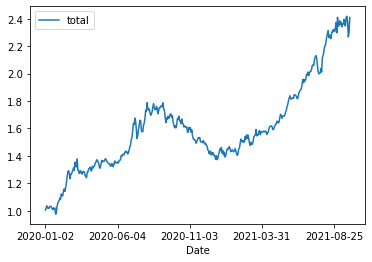

In [80]:
result.plot()
plt.show()